# Analysis of Variation Types in Feature Spaces

## 1. Comparison of Performance of a Traditional Learner in Different Variation Patterns
We try to observe any recurring pattern in terms of performance when variation pattern differs.

In [1]:
import model
import dataloader as dl
import numpy as np
import trainer
import parameters as p
import copy
import seaborn as sns
import matplotlib.pyplot as plt

datasets = ['a8a', 'german', 'ionosphere', 'spambase', 'magic04']
model_type = 'hinge_oco'


# initialize results dict
results = {}
masks = {}
occurrences = {}

for dataset in datasets:
    results[dataset] = {}
    masks[dataset] = {}
    occurrences[dataset] = {}
    for scenario in p.scenarios:
        results[dataset][scenario] = 0
        masks[dataset][scenario] = []

for scenario in p.scenarios:
    for dataset_name in p.datasets:
        Xpath, ypath = dl.get_path(dataset_name)
        X, y = dl.read_dataset(Xpath, ypath)
        num_features = len(X[0])
        m = p.models[model_type](num_features, p.learning_rate)
        fold_errors, fold_losses, fold_weights, fold_masks = trainer.cross_validation(X, y, m, p.folds, p.scenarios[scenario])
        masks[dataset_name][scenario] = fold_masks
        results[dataset_name][scenario] = np.mean(fold_errors)
        print(dataset_name, scenario, model_type, np.mean(fold_errors))
    print()    
    
    
# plot results for each dataset
for dataset_name in datasets:
    plt.title(dataset_name)
    plt.ylabel('Error Rate')
    plt.bar(results[dataset_name].keys(), results[dataset_name].values())
    plt.show()

a8a full hinge_oco 0.16407737046175538
german full hinge_oco 0.3012
ionosphere full hinge_oco 0.36314285714285716
spambase full hinge_oco 0.23931521739130437
magic04 full hinge_oco 0.241682002208318

a8a varying_gaussian hinge_oco 0.4362266478674656
german varying_gaussian hinge_oco 0.5016499999999999
ionosphere varying_gaussian hinge_oco 0.5292857142857142
spambase varying_gaussian hinge_oco 0.4945000000000001
magic04 varying_gaussian hinge_oco 0.4919922183080077

a8a varying_uniform hinge_oco 0.2014694219245682
german varying_uniform hinge_oco 0.3024
ionosphere varying_uniform hinge_oco 0.36314285714285716
spambase varying_uniform hinge_oco 0.3051739130434782
magic04 varying_uniform hinge_oco 0.3222593196277407



<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

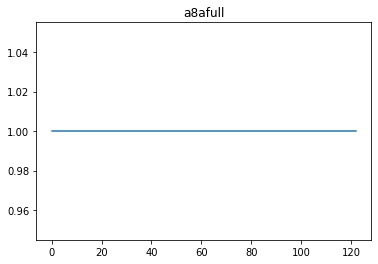

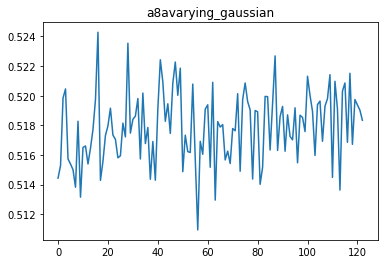

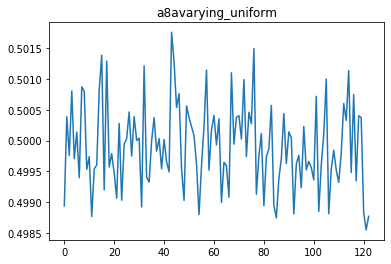

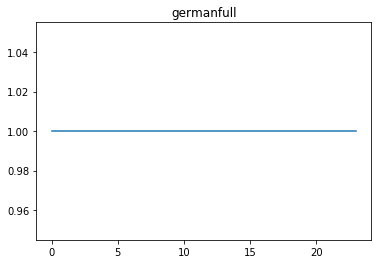

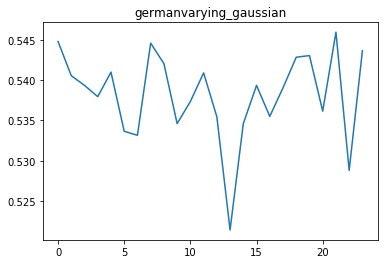

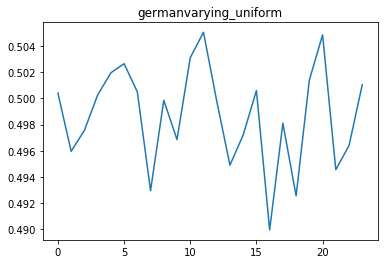

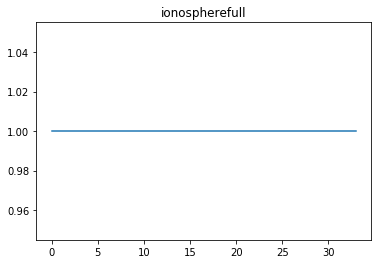

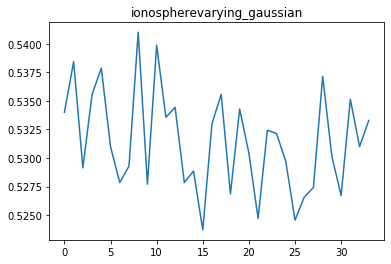

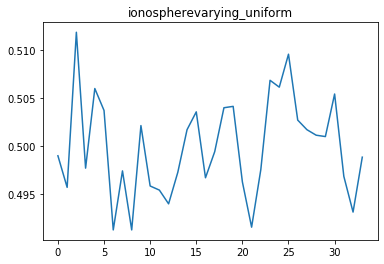

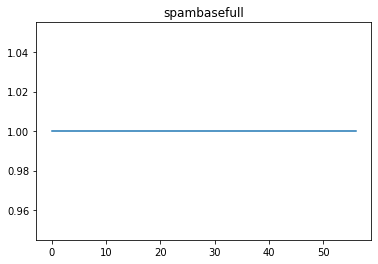

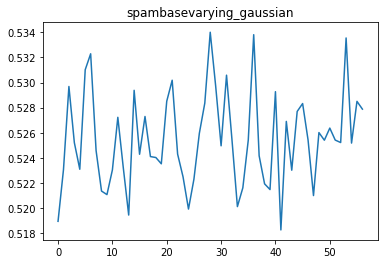

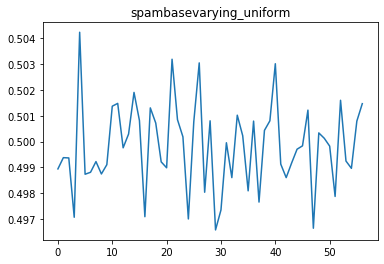

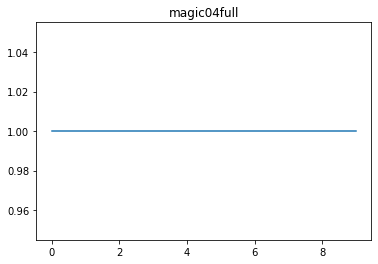

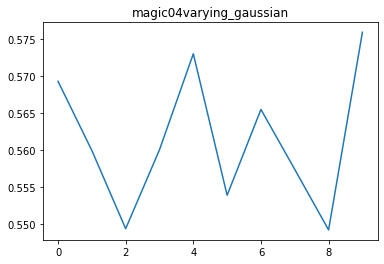

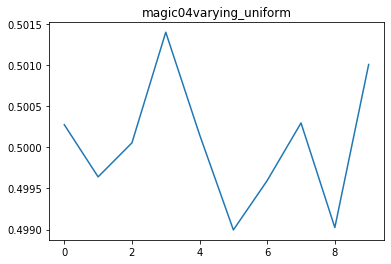

In [2]:
for key in masks:
    for scenario in p.scenarios:
        sum_masks = copy.deepcopy(masks[key][scenario][0])
        for i in range(1, len(masks[key][scenario])):
            sum_masks += masks[key][scenario][i]

        avg_sum_masks =  sum_masks / len(masks[key][scenario])
        avg_sum_masks = np.sum(avg_sum_masks, axis=0) / len(sum_masks)
        occurrences[key][scenario] = avg_sum_masks
        
        plt.title(key + scenario)
        plt.plot(occurrences[key][scenario])
        plt.show()

**We have made two observations so far:**
1. Performance in non-uniformly distributed variation in feature spaces is worse than uniform.
2. Checking the average availability frequency of features don't immediately give an explanation about this.

After this, Jeev suggested to look at the co-occurrences of features.

## Performance vs. Feature Co-Occurrence Patterns
Let us take the *german* dataset and see how feature co-occurrences look like in different versions of the variation.
To do this, we first merge the masks from different folds of cross-validation we have.
Masks represent the feature availability in a training instance, therefore, useful when we are working on structures of feature spaces.


a8a


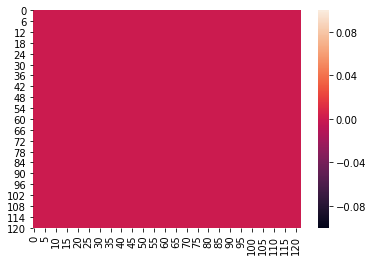

a8a


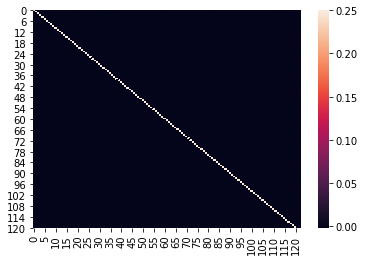

a8a


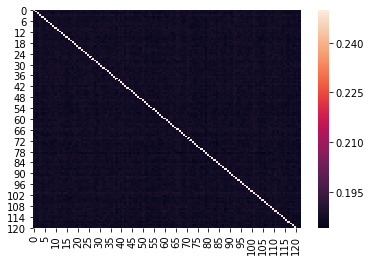

german


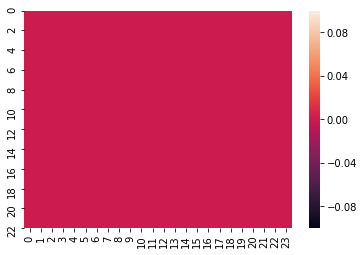

german


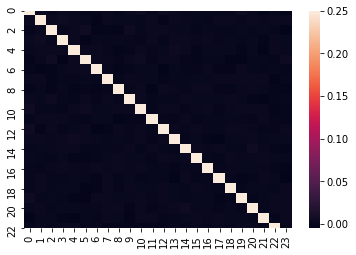

german


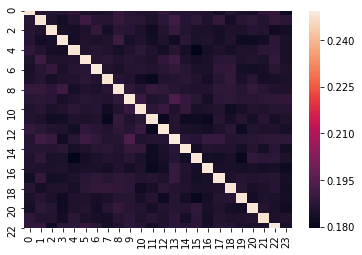

ionosphere


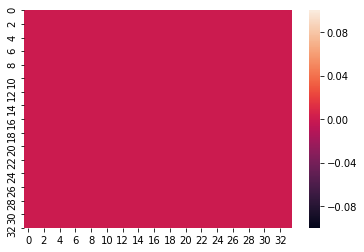

ionosphere


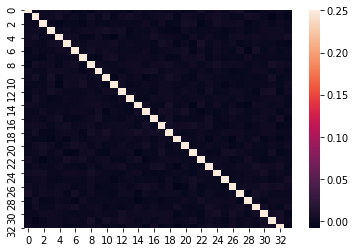

ionosphere


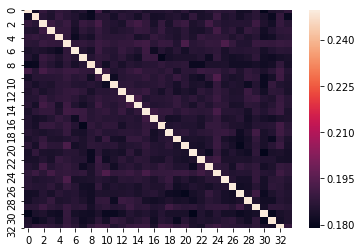

spambase


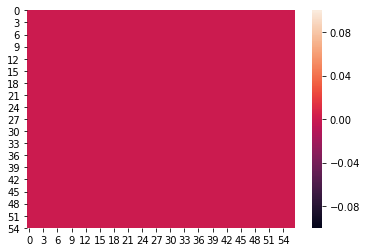

spambase


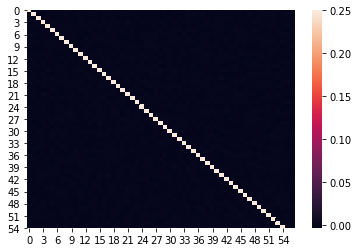

spambase


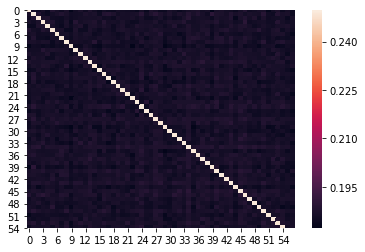

magic04


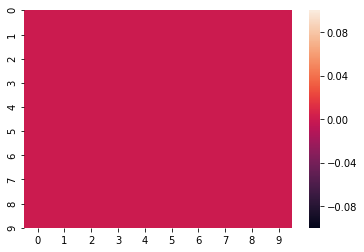

magic04


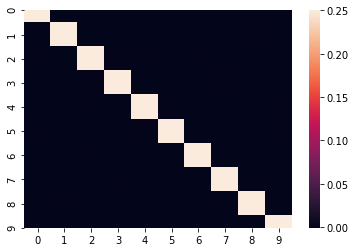

magic04


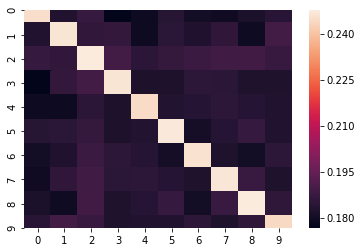

In [4]:
def show_cov_mat(masks, dataset, setting):
    m = masks[dataset][setting]
    joint_mask = m[0]
    
    for i in range(1, len(m)):
        joint_mask = np.vstack((joint_mask, m[i]))
    
    cov_mat = np.cov(joint_mask.T)
    sns.heatmap(cov_mat)
    plt.show()
    return cov_mat


settings = ['full', 'varying_uniform', 'varying_gaussian']

for dataset in datasets:
    for setting in settings:
        print(dataset)
        show_cov_mat(masks, dataset, setting)

We see that an important is that varying feature spaces distribution in a uniform fashion have low covariance -> feature co-occurrence. This means feature occurrences don't follow a particular pattern. On the other hand, for gaussian, there exists various amounts of covariance between features, starting to form a pattern. This seems to be making learning harder for some reason.

**Note:** In both cases, the diagonal of the matrix seems to be 0.25. Diagonals of a covariance matrix are the variances of the components of the vector.

## Relationship Between the Amount of Covariance in Varying Gaussian and the Traditional Model Performance
In this section, we take the generator of varying_gaussian and modify it in a way that it removes features in different levels of variation.